<a href="https://colab.research.google.com/github/RazerRaymond/MachineLearningPS/blob/main/Feature_Engineering_on_Image_Data_and_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering on Image Data and NN

Collaborators: 
Credit Xiaowen Ma for teaching and inspiring me how to concantate dog path and cat path to paths


## 1. Building a Classifier with Generated Features

In the lab, we used a neural network as a feature extractor. We saw that we could use the $k$-means algorithm to cluster images of cats and dogs with their extracted features. We also saw that we could use $k$-nearest neighbors to build a retrieval system, which was capable of taking a new image of a cat and dog, extract its features, and then look up the most similar images in the retrieval system.

Today, we will try to take this a step farther. Instead of just returning the most similar images, we will try to classify a new image. To do this we will try to use Logistic Regression.

### Checking the Data Location

In [ ]:
from os import listdir


base_dir = 'utility/data'

assert 'PetImages' in listdir(base_dir), f'Couldn\'t find `PetImages` in the `{base_dir}` directory of this lab'

### Building Up a Dataset

As you know from the lab, we have 25,000 images in our dataset. There are _way_ too many images for a homework based on feature extraction to be feasible if we used all of them. Instead, we will get the paths of all of the images and sample 400 of them.

In [ ]:
classes = ['Dog', 'Cat']

dog_paths = [f'{base_dir}/PetImages/Dog/{image}' for image in listdir(f'{base_dir}/PetImages/Dog')]
cat_paths = [f'{base_dir}/PetImages/Cat/{image}' for image in listdir(f'{base_dir}/PetImages/Cat')]

In [ ]:
dog_paths[:5]

['utility/data/PetImages/Dog/254.jpg',
 'utility/data/PetImages/Dog/6021.jpg',
 'utility/data/PetImages/Dog/2105.jpg',
 'utility/data/PetImages/Dog/6883.jpg',
 'utility/data/PetImages/Dog/7433.jpg']

### Investigate if data is balanced between cats/dogs

Use the provided `choice` function, which is the same as [`np.random.choice`](https://www.numpy.org/devdocs/reference/generated/numpy.random.choice.html?highlight=choice#numpy.random.choice) with an added `random_state` keyword argument, on both `dog_paths` and `cat_paths` to produce a list of `paths` that contains the paths of images we will use in our dataset. Additionally, please prepare the `labels` for these images. Set the `random_state` to 5.

In [ ]:
import numpy as np

def choice(*args, random_state=None, **kwargs):
    '''
    Has the same function interface as np.random.choice
    except with the addition of a random_state keyword argument (kwarg)
    '''
    
    return np.random.RandomState(seed=random_state).choice(*args, **kwargs)

In [ ]:
# your code here

labels=[]
paths=[]

paths=np.concatenate((choice(dog_paths,200,random_state=5),choice(cat_paths,200,random_state=5)))

for i in range(200):
    labels.append(0)
for j in range(200):
    labels.append(1)

labels=np.array(labels)



assert len(paths) == 400, 'Expected 400 image paths in PATHS'
assert labels.shape == (400,), 'Expected 400 labels'
assert labels.sum() == 200, 'Expected 200 [0, 1] labels for each class'

### Extracting Features

Now that we have the paths of the images we want to use, the next step in our dataset preparation is to extract the features of these images.

### Load Pre-build Functions 
Credit: Brian Garnett and Marion Neumann of WUSTL.

In [ ]:
from utility.util import extract_features

from utility.util import preprocess_image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model


base = VGG16(weights='imagenet')
layer = 'flatten'
extractor = Model(inputs=base.input, outputs=base.get_layer(layer).output)

# your code here
p=[]

for i in range(len(paths)):
    p.append(preprocess_image(preprocess_input,paths[i]))
    
extracted_features=extract_features(extractor,preprocess_input,paths.tolist())

Extracting Features from Images:
..................................................50
..................................................100
..................................................150
..................................................200
..................................................250
..................................................300
..................................................350
..................................................400


### Creating Model

Train test split and initial logistic regression model building

In [ ]:
# your code here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test,idx_train,idx_test = train_test_split(extracted_features, labels,range(400), stratify=labels, test_size=0.25, random_state=8)

In [ ]:
# your code here
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(random_state=11).fit(X_train, y_train)
p_train=model.predict(X_train)
p_test=model.predict(X_test)

missed = 0
j = 0
while j < len(p_train):
    if p_train[j]==y_train[j]:
        missed=missed+1
    j+=1
accuracy=missed/len(p_train)
print("Accuracy: {}!".format(accuracy))

miss = 0
i = 0
while i < len(p_test):
    if p_test[i]==y_test[i]:
        miss=miss+1
    i+=1
testing_acc=miss/len(p_test)

Accuracy: 1.0!


In [ ]:
testing_acc

0.98

### Classifying Cats and Dogs!

Now that we have trained and evaluated our model, let's get to the fun part: looking at pictures of cats and dogs!

Use the `choice` function provided in [Problem 1.1](#Problem-1.1) with a `random_state` of 14 to sample the feature vectors of five images from our testing set. Then, use the Logistic regression model we trained in [Problem 1.4](#Problem-1.4) to classify each of the images, reporting both the class label, $\hat y$, and the probability of that class, $P(y = \hat y \mid x)$. Record the indices of these images in `image_indices`.

In [ ]:
# your code here
image_indices=[]
arr = []

i=0
while i < 5:
    arr.append(extracted_features[idx_test[np.random.choice(len(idx_test))]])
    image_indices.append(idx_test[np.random.choice(len(idx_test))])
    i+=1 
arr_pred = model.predict(arr)

#probability calculation
x=0
j=0
while j < 5:
    if arr_pred[j]==labels[image_indices[j]]:
        x+=1
    j+=1
print(x/5)

0.6


Let's check how our model did.

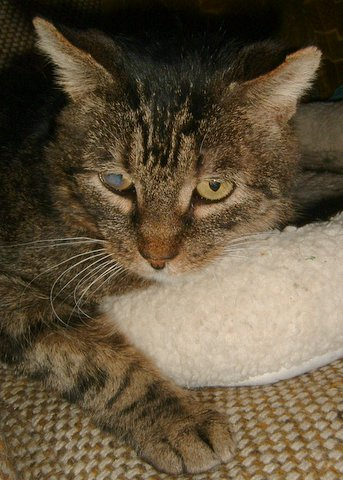

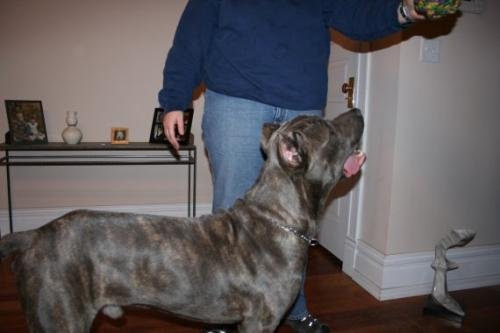

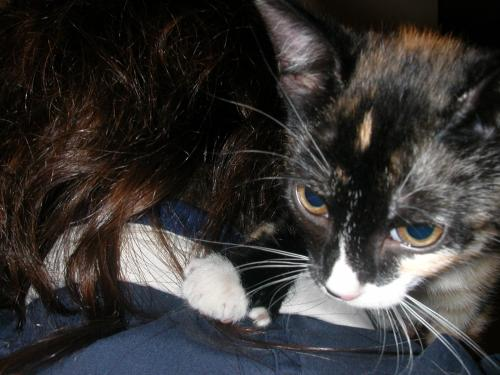

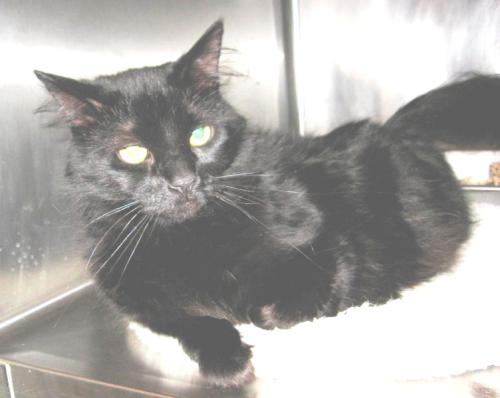

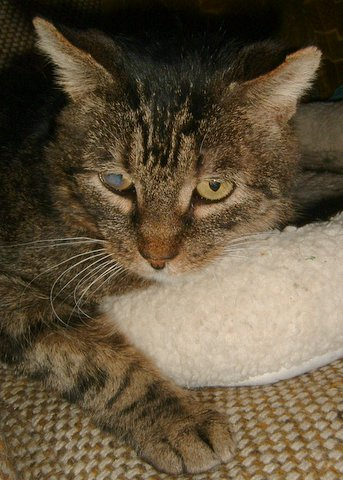

In [ ]:
from utility.util import show_image

for index in image_indices:
    path = paths[index]
    show_image(path)

## 2. Automatic Feature Selection

In this section, we will cover two different methods of selecting features, or in other words, removing some features, to hopefully improve the accuracy of the resulting model by accounting for the effects of overfitting.

### Loading the Data

First, we will load the breast cancer dataset and its 30 features.

In [ ]:
from sklearn.datasets import load_breast_cancer


cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

### Adding Some Noise

We want to simulate what happens when we have too many features, many of which are redundant or are just noise. Let's add  30 features that are random noise.

In [ ]:
noise = np.random.RandomState(28).normal(size=X.shape)
X_noise = np.hstack([X, noise])

### Creating Training, Validation, and Testing Sets

We then split the data into test and train sets, as well as an additional validation set to compare the final results of the models generated.

In the following cell, produce a test set with 20% of the `X_noise`, then use 10% of the remaining data as a validation set. The data left will be our training set. Stratify by the target variable (remember how this data set was unbalanced). Also, use a `random_state` of 13.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# your code here
X_rest, X_test,y_rest,y_test = train_test_split(X_noise,y,stratify=y, test_size=0.2, random_state=13)
X_train,X_val,y_train,y_val= train_test_split(X_rest, y_rest,stratify=y_rest,test_size=0.1, random_state=13)

### Model-Based Feature Selection

In model-based feature selection, a model (that could be different from the one used to train the data) selects the features that are most important by looking at the `feature_importances_` attribute that decision tree models provide. It accounts for interactions between features as well, unlike some other methods that only look at features individually.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(n_estimators=100, random_state=28)
select = SelectFromModel(model, threshold="median")

We use a random forest classifier with 100 trees to compute the feature importances, and select half of the 60 features (this is the 'threshold="median"' parameter. A random forest classifier uses multiple decision trees on different subsets of the data to reduce the tendency for trees to overfit.

In [ ]:
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print(f'   Noisy Features: {X_train.shape}')
print(f'Selected Features: {X_train_selected.shape}')

   Noisy Features: (409, 60)
Selected Features: (409, 30)


To see what has been selected, we can plot an array of the indices of the features. A black index indicates a selected feature.

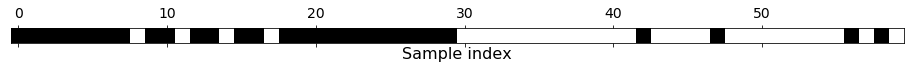

In [ ]:
import matplotlib.pyplot as plt
from utility.util import configure_plots

# run this twice!
configure_plots()

mask = select.get_support()

plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

### Compare Original and selected dataset

Create two new `LogisticRegression` models. Fit the first with the noisy training data `X_train` and the feature-selected training set `X_train_selected`. Then, use the selector to transform the noisy test set `X_test` and store the result in `X_test_selected`. Finally, evaluate both models with their respective test sets and report the results. Use a `random_state` of 15 and set the solver for both models to be `liblinear`.

In [ ]:
from sklearn.linear_model import LogisticRegression


# your code here
newM=LogisticRegression(random_state=15,solver='liblinear').fit(X_train, y_train)
print(newM.score(X_test,y_test))
newerM=LogisticRegression(random_state=15,solver='liblinear').fit(X_train_selected, y_train)
X_test_selected=select.transform(X_test)
print(newerM.score(X_test_selected,y_test))

0.9298245614035088
0.9210526315789473


### Iterative Feature Selection

In iterative feature selection, a series of models are built, removing or building up one feature at a time, as opposed to constructing one model from which the entire selection is made. A particular kind of this is this is [**recursive feature elimination** (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), which starts with all features, builds a model, and discards the least important feature according to the model. Then a new model is built using all but the discarded feature, and so on until only a prespecified number of features are left. For this to work, the model used for selection needs to provide some way to determine feature importance, as was the case for the model-based selection. Here, we use the same random forest model that we used earlier.

In this code, we will run 40 iterations of RFE, selecting 59 of the 60 features, then 58, and so on, until only 20 are selected. At this point, we expect the accuracy to be somewhat lower, given that we would have to get rid of some of the original 30 features. We also save the features at the iteration that selects 30, to compare to the ones selected above.

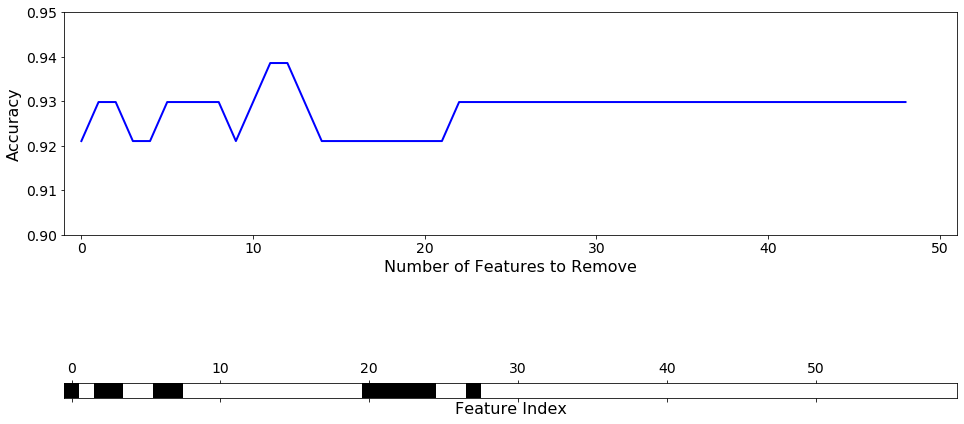

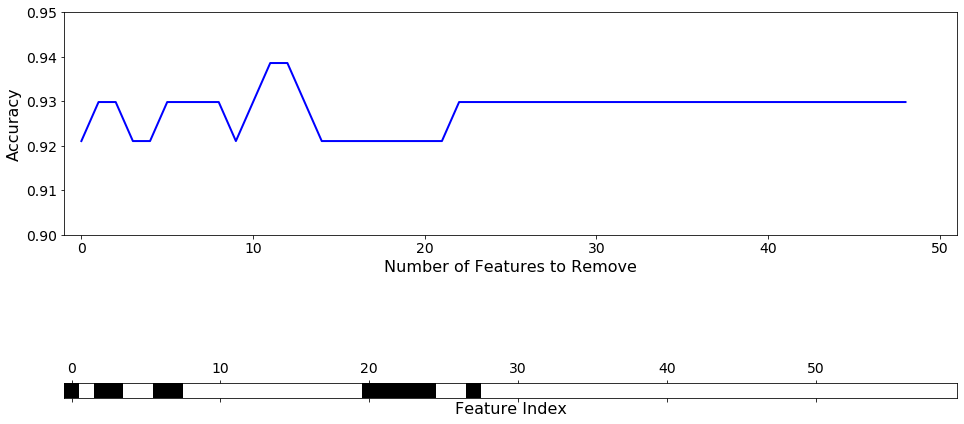

In [ ]:
from sklearn.feature_selection import RFE
from IPython import display

scores, masks = [], []

#set up axes for plot
fig, (ax1, ax2) = plt.subplots(2, 1)

for number_to_remove in range(1, 50):
    model = RandomForestClassifier(n_estimators=100, random_state=28)
    selector = RFE(model, n_features_to_select=60-number_to_remove)
    selector.fit(X_train, y_train)

    # create and save masks
    masks.append(selector.get_support())
    
    X_train_rfe = selector.transform(X_train)
    X_test_rfe = selector.transform(X_test)
    
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    
    scores.append(score)

    # update plot
    ax1.clear()
    ax1.plot(scores, 'b-')
    ax1.set_xlim(-1, 51)
    ax1.set_ylim(0.90, 0.95)
    ax1.set_xlabel('Number of Features to Remove')
    ax1.set_ylabel('Accuracy')

    ax2.matshow(selector.get_support().reshape(1, -1), cmap='gray_r')
    ax2.set_yticks(())
    ax2.set_xlabel('Feature Index')
    
    display.clear_output(wait=True)
    display.display(fig)

As you can see, feature selection has a generally positive impact on this data set, given that we added 30 extra features of noise. However, it is a tool you should keep in mind when combatting overfitting. But, beware of the impact of removing too many features too.

([], <a list of 0 Text yticklabel objects>)

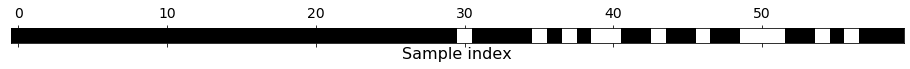

In [ ]:
# your code here
best_mask=masks[11]

plt.matshow(best_mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())